<a href="https://colab.research.google.com/github/HmmNcip/BDPA-LANJUTA/blob/main/UAS_BDPA_Lanjut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# --- UAS BDPA Lanjut ---

## Anggota Kelompok :
#### 1. Resky Aulia                    (21.11.4468)
#### 2. SeptianDitya Ilham Ciptadi     (21.11.4502)

In [1]:
# --- 1. INSTALL DEPENDENCIES ---
!pip install -q kagglehub pyspark

# --- 2. IMPORT LIBRARY ---
import os
import kagglehub
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# PySpark Core & SQL
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, from_json, to_timestamp, hour, dayofweek, count, when, date_format
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, FloatType, TimestampType

# PySpark ML (Machine Learning)
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# --- 3. INISIALISASI SPARK SESSION ---
spark = SparkSession.builder \
    .appName("TA_BigData_Ecommerce_Prediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print(" Setup Selesai! Spark Version:", spark.version)

 Setup Selesai! Spark Version: 4.0.1


In [2]:
# --- DOWNLOAD DATASET ---
print("Sedang mendownload dataset...")
path = kagglehub.dataset_download("mkechinov/ecommerce-events-history-in-electronics-store")

# Cari file CSV secara otomatis di dalam folder hasil download
csv_files = [f for f in os.listdir(path) if f.endswith('.csv
print(f"Total Baris Data: {df_raw.count():,}") # Cek Volume
df_raw.show(5)
df_raw.printSchema()

Sedang mendownload dataset...


100%|██████████| 20.3M/20.3M [00:00<00:00, 82.7MB/s]

Extracting files...


File ditemukan: /root/.cache/kagglehub/datasets/mkechinov/ecommerce-events-history-in-electronics-store/versions/1/events.csv
Total Baris Data: 885,129
+-------------------+----------+----------+-------------------+--------------------+-----------+------+-------------------+------------+
|         event_time|event_type|product_id|        category_id|       category_code|      brand| price|            user_id|user_session|
+-------------------+----------+----------+-------------------+--------------------+-----------+------+-------------------+------------+
|2020-09-24 11:57:06|      view|   1996170|2144415922528452715|electronics.telep...|       NULL|  31.9|1515915625519388267|  LJuJVLEjPT|
|2020-09-24 11:57:26|      view|    139905|2144415926932472027|computers.compone...|     zalman| 17.16|1515915625519380411|  tdicluNnRY|
|2020-09-24 11:57:27|      view|    215454|2144415927158964449|                NULL|       NULL|  9.81|1515915625513238515|  4TMArHtXQy|
|2020-09-24 11:57:33|     

In [3]:
# 3.a: Batch Processing (MapReduce)
# ==========================================

# 1. Konversi DataFrame ke RDD
# Kita ambil kolom 'brand' dari data mentah
rdd_raw = df_raw.select("brand").rdd

# 2. MapReduce Pipeline
# Filter data yang nama brand-nya kosong (None) agar tidak error
# Map: Ubah ("Samsung") menjadi ("Samsung", 1)
# Reduce: Jumlahkan value untuk key yang sama
result_rdd = rdd_raw.filter(lambda row: row['brand'] is not None) \
                    .map(lambda row: (row['brand'], 1)) \
                    .reduceByKey(lambda a, b: a + b)

# 3. Menampilkan Hasil (Action)
# Urutkan data terbanyak (descending) dan ambil 5 teratas
top_5_brands = result_rdd.takeOrdered(5, key=lambda x: -x[1])

print("--- [Output 3.a] Hasil MapReduce Batch Processing ---")
print("Top 5 Brand Paling Aktif:")
for brand, total in top_5_brands:
    print(f"Brand: {brand}, Total Aktivitas: {total}")

--- [Output 3.a] Hasil MapReduce Batch Processing ---
Top 5 Brand Paling Aktif:
Brand: asus, Total Aktivitas: 27706
Brand: gigabyte, Total Aktivitas: 27673
Brand: msi, Total Aktivitas: 24877
Brand: palit, Total Aktivitas: 24802
Brand: samsung, Total Aktivitas: 23208


/tmp/ipython-input-4037703405.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='event_type', y='count', data=df_event_dist, palette='viridis')


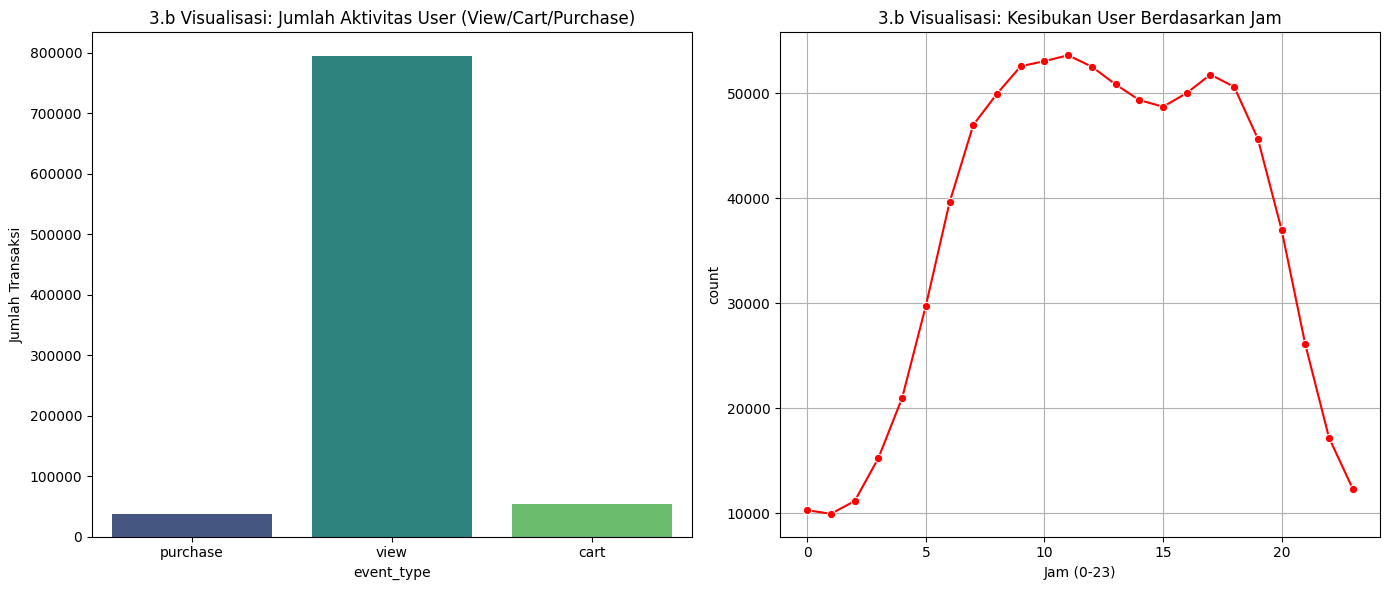

--- [Output 3.b] Analisa EDA Selesai ---
Insight: Kita bisa melihat jam sibuk dan perbandingan jumlah orang yg cuma lihat vs beli.


In [4]:
# 3.b: EDA & Visualisasi
# ==========================================

#  Distribusi Tipe Event
# Hitung nilai pada Spark (Distributed), setelah itu konversi ke Pandas
df_event_dist = df_raw.groupBy("event_type").count().toPandas()

# Analisa aktivitas user
df_hourly = df_raw.withColumn("jam", hour(col("event_time"))) \
                  .groupBy("jam").count().orderBy("jam").toPandas()

# --- VISUALISASI ---
plt.figure(figsize=(14, 6))

# Plot 1: Bar Chart Event Type
plt.subplot(1, 2, 1)
sns.barplot(x='event_type', y='count', data=df_event_dist, palette='viridis')
plt.title('3.b Visualisasi: Jumlah Aktivitas User (View/Cart/Purchase)')
plt.ylabel('Jumlah Transaksi')

# Plot 2: Line Chart Activity per Hour
plt.subplot(1, 2, 2)
sns.lineplot(data=df_hourly, x='jam', y='count', marker='o', color='red')
plt.title('3.b Visualisasi: Kesibukan User Berdasarkan Jam')
plt.xlabel('Jam (0-23)')
plt.grid(True)

plt.tight_layout()
plt.show()

print("--- [Output 3.b] Analisa EDA Selesai ---")
print("Insight: Kita bisa melihat jam sibuk dan perbandingan jumlah orang yg cuma lihat vs beli.")

In [5]:
# 3.c: Preprocessing & Data Quality
# ==========================================

print("--- [Output 3.c] Proses Cleaning Data ---")

# 1. Casting Tipe Data (untuk Time Series)
df_clean = df_raw.withColumn("event_time", to_timestamp(col("event_time"), "yyyy-MM-dd HH:mm:ss z"))

# 2. Handling Missing Value (Strategy)
# a. Critical Columns: user_id & product_id
df_clean = df_clean.dropna(subset=["user_id", "product_id"])

# b. Categorical Columns: brand & category_code data tidak dihapus walapun data kosong
df_clean = df_clean.fillna({
    'brand': 'unknown',
    'category_code': 'others'
})

# 3. Filtering Data Aneh (Data Quality)
# Harga (price) tidak boleh negatif
df_clean = df_clean.filter(col("price") >= 0)

# Cek hasil cleaning
print(f"Data Awal: {df_raw.count()} baris")
print(f"Data Bersih: {df_clean.count()} baris")
df_clean.printSchema()

--- [Output 3.c] Proses Cleaning Data ---
Data Awal: 885129 baris
Data Bersih: 885129 baris
root
 |-- event_time: timestamp (nullable = true)
 |-- event_type: string (nullable = true)
 |-- product_id: integer (nullable = true)
 |-- category_id: long (nullable = true)
 |-- category_code: string (nullable = false)
 |-- brand: string (nullable = false)
 |-- price: double (nullable = true)
 |-- user_id: long (nullable = true)
 |-- user_session: string (nullable = true)



In [6]:
# 3.d: Manipulasi Data Spark SQL
# ==========================================

# 1. Register Temp View
df_clean.createOrReplaceTempView("ecommerce_logs")

# 2. Complex Query (CTE + Aggregation)
# Mencari data user yang sudah melakukan pembelian (purchase) lebih dari 1 kali.
query_complex = """
/* CTE: Hitung dulu total belanjaan per user */
WITH UserPurchaseStats AS (
    SELECT
        user_id,
        count(*) as total_transaksi,
        sum(price) as total_uang_keluar
    FROM ecommerce_logs
    WHERE event_type = 'purchase'
    GROUP BY user_id
)

/* Main Query: Filter cuma user 'Sultan' (beli > 1 kali) */
SELECT
    user_id,
    total_transaksi,
    ROUND(total_uang_keluar, 2) as total_spent
FROM UserPurchaseStats
WHERE total_transaksi > 1
ORDER BY total_spent DESC
"""

print("--- [Output 3.d] Hasil Query SQL (High Value Users) ---")
spark.sql(query_complex).show(5)

--- [Output 3.d] Hasil Query SQL (High Value Users) ---
+-------------------+---------------+-----------+
|            user_id|total_transaksi|total_spent|
+-------------------+---------------+-----------+
|1515915625601579158|             56|   12080.83|
|1515915625530137422|             18|    9418.62|
|1515915625547240612|             16|    8639.69|
|1515915625600723220|             19|    8447.61|
|1515915625596222123|             24|    8047.99|
+-------------------+---------------+-----------+
only showing top 5 rows


In [7]:
# 3.e: Operasi RDD & Partitioning
# ==========================================

# 1. Persiapan RDD Pair (Key, Value) -> (Brand, Price)
# Mengambil data 'purchase'
rdd_purchase = df_clean.filter(col("event_type") == "purchase") \
                       .select("brand", "price").rdd \
                       .map(lambda row: (row['brand'], row['price']))

# 2. Custom Partitioning
# Set 4 partisi menggunakan HashPartitioner
# Mengelompokkan brand yang sama ke node yang sama biar ngitungnya cepet.
rdd_partitioned = rdd_purchase.partitionBy(4, lambda x: hash(x))

# 3. AggregateByKey
total_omset_rdd = rdd_partitioned.aggregateByKey(
    0.0,                           # Nilai awal
    lambda acc, price: acc + price, # Step 1: Jumlahkan harga di tiap partisi lokal
    lambda acc1, acc2: acc1 + acc2  # Step 2: Gabungkan hasil total antar partisi
)

# Tampilkan Hasil
print("--- [Output 3.e] Total Omset per Brand (RDD Partitioned) ---")
top_omset = total_omset_rdd.takeOrdered(5, key=lambda x: -x[1])

for brand, omset in top_omset:
    print(f"Brand: {brand}, Omset: ${omset:,.2f}")

print(f"\nInfo: Operasi dilakukan dengan {rdd_partitioned.getNumPartitions()} partisi.")

--- [Output 3.e] Total Omset per Brand (RDD Partitioned) ---
Brand: msi, Omset: $643,492.34
Brand: unknown, Omset: $594,729.99
Brand: gigabyte, Omset: $556,183.04
Brand: palit, Omset: $484,210.58
Brand: asus, Omset: $330,147.11

Info: Operasi dilakukan dengan 4 partisi.


In [8]:
# 4: CLEAN & BALANCED
# ==========================================

print("--- Persiapan Data (Undersampling Technique) ---")

# 1. Labeling
df_labeled = df_clean.withColumn("label", when(col("event_type") == "purchase", 1).otherwise(0))

# 2. UNDERSAMPLING
df_purchase = df_labeled.filter(col("label") == 1)
df_view = df_labeled.filter(col("label") == 0)

# Hitung jumlah yang beli
count_purchase = df_purchase.count()
print(f"Jumlah User Beli: {count_purchase}")

# Ambil sampel user yang TIDAK BELI sejumlah user yang BELI
# ratio = jumlah_beli / jumlah_view
ratio = count_purchase / df_view.count()
df_view_sampled = df_view.sample(withReplacement=False, fraction=ratio, seed=42)

# Gabungkan kembali
df_ml_balanced = df_purchase.union(df_view_sampled)
print(f"Total Data Training setelah Balancing: {df_ml_balanced.count()}")

# 3. Handling Categorical Features
indexer_brand = StringIndexer(inputCol="brand", outputCol="brand_idx").setHandleInvalid("keep")
indexer_cat = StringIndexer(inputCol="category_code", outputCol="cat_idx").setHandleInvalid("keep")

# 4. Vector Assembler
assembler = VectorAssembler(
    inputCols=["price", "brand_idx", "cat_idx"],
    outputCol="features"
)

# 5. Split Data (80% Training, 20% Testing)
train_data, test_data = df_ml_balanced.randomSplit([0.8, 0.2], seed=123)

# --- DEFINISI MODEL ---
lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10)
# maxBins
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=20, maxBins=4000)

# --- PIPELINE ---
pipeline_lr = Pipeline(stages=[indexer_brand, indexer_cat, assembler, lr])
pipeline_rf = Pipeline(stages=[indexer_brand, indexer_cat, assembler, rf])

print("\nSedang melatih model Logistic Regression...")
model_lr = pipeline_lr.fit(train_data)

print("Sedang melatih model Random Forest...")
model_rf = pipeline_rf.fit(train_data)

print("\n Training Selesai dengan Data Seimbang!")

--- Persiapan Data (Undersampling Technique) ---
Jumlah User Beli: 37346
Total Data Training setelah Balancing: 74689

Sedang melatih model Logistic Regression...
Sedang melatih model Random Forest...

 Training Selesai dengan Data Seimbang!


In [9]:
# 5: Hyperparameter Tuning
# ==========================================

print("--- Memulai Hyperparameter Tuning ---")
print("Proses ini akan melatih model berkali-kali (Cross Validation).")
print("Mohon tunggu, ini mungkin memakan waktu 2-5 menit tergantung koneksi Colab...")

# 1. Tentukan Grid Parameter
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [20, 50]) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .build()

# 2. Definisikan Evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# 3. Setup Cross Validator
cv = CrossValidator(
    estimator=pipeline_rf,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

# 4. Jalankan Tuning
cv_model = cv.fit(train_data)

# 5. Ambil Model Terbaik
best_model = cv_model.bestModel

# --- INTERPRETASI HASIL ---
print("\nTuning Selesai! Model terbaik ditemukan.")

# Mengakses stage terakhir dari pipeline (RandomForestClassifier adalah stage terakhir/index -1)
best_rf_stage = best_model.stages[-1]

print(f"Parameter Terbaik -> Jumlah Pohon (NumTrees): {best_rf_stage.getNumTrees}")
print(f"Parameter Terbaik -> Kedalaman Pohon (MaxDepth): {best_rf_stage.getOrDefault('maxDepth')}")

# Cek performa model terbaik di data testing
predictions_tuned = best_model.transform(test_data)
auc_tuned = evaluator.evaluate(predictions_tuned)

print(f"\nFinal AUC Score (Best Model): {auc_tuned:.4f}")
print("Interpretasi: Skor AUC di atas 0.7 masuk kategori Fair/Good, di atas 0.8 Very Good.")

--- Memulai Hyperparameter Tuning ---
Proses ini akan melatih model berkali-kali (Cross Validation).
Mohon tunggu, ini mungkin memakan waktu 2-5 menit tergantung koneksi Colab...

Tuning Selesai! Model terbaik ditemukan.
Parameter Terbaik -> Jumlah Pohon (NumTrees): 50
Parameter Terbaik -> Kedalaman Pohon (MaxDepth): 10

Final AUC Score (Best Model): 0.6901
Interpretasi: Skor AUC di atas 0.7 masuk kategori Fair/Good, di atas 0.8 Very Good.


In [10]:
# 6: Evaluasi & Komparasi Model
# ==========================================

print("--- Perbandingan Performa Model Final ---")

# 1. Lakukan Prediksi untuk KEDUA Model
# Prediksi dgn Logistic Regression (Model Sederhana)
preds_lr = model_lr.transform(test_data)

# Prediksi dgn Random Forest Terbaik (Model Kompleks Hasil Tuning)
preds_rf = best_model.transform(test_data)

# 2. Siapkan Evaluator
ev_acc = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
ev_f1  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
ev_prec = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
ev_rec  = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")

# 3. Hitung Metrik Logistic Regression (LR)
acc_lr = ev_acc.evaluate(preds_lr)
f1_lr = ev_f1.evaluate(preds_lr)
prec_lr = ev_prec.evaluate(preds_lr)
rec_lr = ev_rec.evaluate(preds_lr)

# 4. Hitung Metrik Random Forest (RF)
acc_rf = ev_acc.evaluate(preds_rf)
f1_rf = ev_f1.evaluate(preds_rf)
prec_rf = ev_prec.evaluate(preds_rf)
rec_rf = ev_rec.evaluate(preds_rf)

# 5. Tampilkan Tabel Perbandingan
print(f"\n{'METRIC':<15} | {'LOGISTIC REGRESSION':<20} | {'RANDOM FOREST (TUNED)':<20}")
print("-" * 65)
print(f"{'Accuracy':<15} | {acc_lr:<20.2%} | {acc_rf:<20.2%}")
print(f"{'Precision':<15} | {prec_lr:<20.2%} | {prec_rf:<20.2%}")
print(f"{'Recall':<15} | {rec_lr:<20.2%} | {rec_rf:<20.2%}")
print(f"{'F1-Score':<15} | {f1_lr:<20.2%} | {f1_rf:<20.2%}")
print("-" * 65)

# 6. Kesimpulan Otomatis
print("\n--- Kesimpulan ---")
if acc_rf > acc_lr:
    print("Model Random Forest (Tuned) memiliki performa lebih baik dibanding Logistic Regression.")
else:
    print("Model Logistic Regression ternyata cukup baik jika dibandingkan dengan Random Forest.")

--- Perbandingan Performa Model Final ---

METRIC          | LOGISTIC REGRESSION  | RANDOM FOREST (TUNED)
-----------------------------------------------------------------
Accuracy        | 56.23%               | 64.43%              
Precision       | 56.79%               | 64.69%              
Recall          | 56.23%               | 64.43%              
F1-Score        | 54.87%               | 64.19%              
-----------------------------------------------------------------

--- Kesimpulan ---
Model Random Forest (Tuned) memiliki performa lebih baik dibanding Logistic Regression.
